# Hi, kagglers!

**Note 1** *Sorry for my english, and non-optimized code*

**Note 2** *I used there just one thing from notebook of some guy, and can't find it again to make a reference :( (it's scatter + kde plot design)*

**Note 3** *Kurt would have loved python :)*

It is my work for CLRP Competition! I hope you'll get something useful there.
My name is Yuri, I'm novice on Kaggle :) 
Also I need some help, I tell it in the last cell of this nb.
Waiting your point by comment;)

In [ ]:
%pip install textstat
%pip install eng_to_ipa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
from math import ceil
from collections import Counter
import nltk
from nltk import pos_tag
import eng_to_ipa as ipa
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error as MSE
import re
import textstat
# from tqdm import tqdm
# import torch
# import transformers as ppb

# Description
Can machine learning identify the appropriate reading level of a passage of text, and help inspire learning? Reading is an essential skill for academic success. When students have access to engaging passages offering the right level of challenge, they naturally develop reading skills.

Currently, most educational texts are matched to readers using traditional readability methods or commercially available formulas. However, each has its issues. Tools like Flesch-Kincaid Grade Level are based on weak proxies of text decoding (i.e., characters or syllables per word) and syntactic complexity (i.e., number or words per sentence). As a result, they lack construct and theoretical validity. At the same time, commercially available formulas, such as Lexile, can be cost-prohibitive, lack suitable validation studies, and suffer from transparency issues when the formula's features aren't publicly available.

CommonLit, Inc., is a nonprofit education technology organization serving over 20 million teachers and students with free digital reading and writing lessons for grades 3-12. Together with Georgia State University, an R1 public research university in Atlanta, they are challenging Kagglers to improve readability rating methods.

In this competition, you’ll build algorithms to rate the complexity of reading passages for grade 3-12 classroom use. To accomplish this, you'll pair your machine learning skills with a dataset that includes readers from a wide variety of age groups and a large collection of texts taken from various domains. Winning models will be sure to incorporate text cohesion and semantics.

If successful, you'll aid administrators, teachers, and students. Literacy curriculum developers and teachers who choose passages will be able to quickly and accurately evaluate works for their classrooms. Plus, these formulas will become more accessible for all. Perhaps most importantly, students will benefit from feedback on the complexity and readability of their work, making it far easier to improve essential reading skills. 

# Evaluation

Submissions are scored on the root mean squared error. RMSE is defined as:
# $ RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \widehat{y_i})^2} $
where is the predicted value,   is the original value, and   is the number of rows in the test data.

# First glance
Let us say, there are $m$ different excerpts, so its $T = \{ t_1, t_2, ..., t_m \}$.
Also we could use $k$ omnifarious features: $X = \{ x_1, x_2, ..., x_k \}$. Obviously, the set $X$ is countable, cause we able to use all operations to create new features by olds. So we have $n$ estimators of our excerpts. (We assume that all assessors used their own model and participated in each assessment)
Finally, $D = \{ d_1, d_2, ..., d_k \}$, where $d_i$ is amount of using $x_i$, $ i\in N$, $i\in [1, k]$, and $f: X\leftrightarrow D$ 

*Example:* Let $n=2$, and $ M_1(x_1, x_2, x_4)$ & $ M_2(x_1, x_4, x_5)$ - models of estimators 1 & 2, $x_1(t_i), x_2(t_i), x_3(t_i), x_4(t_i), x_5(t_i)$ - features applied to the text $t_i$. We also guess, that $x$ features transformed to some kind that: $M_1 = x_1 + x_2 + x_4$, $M_2 = x_1 + x_4 + x_5$. If we think that final model is: $M = \frac{M_1 + M_2}{2}$, we have $d_1 = 2$, $d_2 = 1$, $d_3 = 0$, $d_4 = 2$, $d_5 = 1$ 

We get: $y_j = \frac{1}{n}\sum_{i=1}^{k}d_ix_i(t_j)$, where: $d_i\in Z$, $d_i\in [0, n]$
Or: $y_j = \sum_{i=1}^{k}p_ix_i(t_j)$, where: $p_i\in [0, 1]$, $p_i$ is frequency or probability of using $x_i$, $p_i=1$ - everyone used, and, accordingly, $p_i=0$ - no one.

This would be a good model using probabilities as weights, but the idea is too simple to be true. Getting a large number of features, single estimators using different models, a variable number of estimators evaluating excerpts etc.- the model is more complex than we thought. 

And later we saw this...

> Hi everyone, 
Wanted to post this so it be nearer the top. I have posted similar items in various discussions, but the discussion board is very healthy and I am afraid they are getting lost.
The target value is the result of a Bradley-Terry analysis of more than 111,000 pairwise comparisons between excerpts. Teachers spanning grades 3-12  a majority teaching between grade 6-10 served as the raters for these comparisons.
Standard error is included as an output of the Bradley-Terry analysis because individual raters saw only a fraction of the excerpts, while every excerpt was seen by numerous raters. The test and train sets were split after the target scores and s.e. were computed.
Great to see such a spirited competition!

Scott Crossley, competition host

"Target is the result of a Bradley-Terry analysis of more than 111,000 pairwise comparisons between excerpts..."
Obviously, 111000 less than $\binom{m}{2}$, also "readability" of text, should be positive number, to be compared by Bradley-Terry, but we have negative as well. And we have interesting dependence between index and target:
# $index \approx \frac{length}{(e^{target+mt}+1)^n}$
where $mt$ is median of target, and $n$ is something like curvature factor

In [ ]:
tt = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
tn = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
tn.head()

In [ ]:
totalen = tt.shape[0] + tn.shape[0]
(totalen + 1)/2, (totalen * (totalen - 1)) / 2

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=tn.target, y=tn.standard_error, s=10, color=".15")
sns.kdeplot(x=tn.target, y=tn.standard_error, levels=5, color="r", linewidths=1)
plt.show()

In [ ]:
tn = tn.drop(tn[tn.standard_error == 0].index[0])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x=tn.target, y=tn.standard_error, s=10, color=".15")
sns.kdeplot(x=tn.target, y=tn.standard_error, levels=5, color="r", linewidths=1)
plt.show()

In [ ]:
sorted_tn = tn.sort_values('target', ascending=False)
sorted_tn.index = range(len(sorted_tn))
sorted_tn

In [ ]:
# these features was getting during the first running in txt_values() func
# I uploaded its there (ttt.csv), because ipa.convert() works so long...
sorted_tn[['t_length', 'coeff']] = pd.read_csv('../input/length/ttt.csv').drop('Unnamed: 0', axis=1)

Now we're seeing this:
# $index \approx \frac{length}{(e^{target+mt}+1)^n}$
Also we able to know $n$, but we shouldn't care about it at all
So graph below:

In [ ]:
plt.plot(sorted_tn.target, sorted_tn.index, 'black')

In [ ]:
tn.license.unique()

In [ ]:
plt.plot(sorted_tn.standard_error, sorted_tn.index, 'g')

In [ ]:
unq_lisence = dict()
number = 1
for k in sorted_tn.license.unique():
    unq_lisence[k] = number
    number += 1

def licensed(value):
    return unq_lisence[value]

In [ ]:
links = sorted_tn[sorted_tn.url_legal.isnull() == False].url_legal.unique()

In [ ]:
links_set = set()
for link in links:
    pattern = r'://[a-z, 0-9 | \.]+/'
    site = re.findall(pattern, link)[0][3:-1]
    links_set.add(site)

In [ ]:
lists_dict = {}
number = 1
for k in sorted(links_set):
    lists_dict[k] = number
    number += 1    
lists_dict

In [ ]:
def link_distrib(value):
    
    if isinstance(value, str):
        for k, v in lists_dict.items():
            if value[8:].startswith(k):
                return v
    return 0

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(15, 5))

axes[0].set(title='License distribution')
axes[0].plot(sorted_tn.license.apply(licensed), [-i for i in range(len(sorted_tn))], 'ro')
axes[1].set(title='URL distribution')
axes[1].plot(sorted_tn.url_legal.apply(link_distrib), [-i for i in range(len(sorted_tn))], 'go')

In [ ]:
tt.url_legal.apply(link_distrib), lists_dict

In [ ]:
k = 0

indices5, indices12 = [], []
for url in sorted_tn.url_legal:
    if isinstance(url, str):
        if url[8:].startswith('en.wikipedia.org'):
            indices5.append(k)
        elif url[8:].startswith('www.africanstorybook.org'):
            indices12.append(k)
    k += 1

sns.histplot(indices5, kde=True, color="r", label='en.wikipedia.org')
sns.histplot(indices12, kde=True, label='www.africanstorybook.org')
plt.legend()

In [ ]:
def txt_values(text, test=False, with_tags=False):
    
    text = text.lower()
       
    pattern = r'[a-z]+-[a-z]+|[a-z]+'
    sentences, words, tags = [], [], []
    ind_1 = 0
    for ind_2 in range(len(text)):
        if text[ind_2] == '.' or text[ind_2] == '!' or text[ind_2] == '?':
            if text[ind_2 - 1] != '.' or text[ind_2] != '!' or text[ind_2] != '?':
                sentences.append(text[ind_1:ind_2])
                ind_1 = ind_2
    sentences = [sentences[0]] + list(map(lambda x: x[2:], sentences[1:]))
        
    for sentence in sentences:
         words += re.findall(pattern, sentence)
            
    if test:
#         I used ipa with train when was the first running. It locates in ttt.csv
        transcripted = ''
        for word in words:
            transcripted += ipa.convert(word).replace(':', '').replace("'", '').replace('.', '')    
            
    tagged_words = pos_tag(words)
    tags = list(map(lambda x: x[1], tagged_words))
    
    if test:
        t_text_length = len(transcripted)
        
    text_length = len(''.join(words))
    nof_syllables = textstat.syllable_count(text)
    nof_words = len(words)
    nof_sentences = len(sentences)
    avg_len_syllable = text_length / nof_syllables
    avg_len_word = text_length / nof_words
    avg_len_sentence = text_length / nof_sentences
    gunning = textstat.gunning_fog(text)
    ari = textstat.automated_readability_index(text)
    coliau = textstat.coleman_liau_index(text)
    lwf = textstat.linsear_write_formula(text)
    FR_ease = 206.835 - 1.015 * (nof_words / nof_sentences) - 84.6 * (nof_syllables / nof_words)
    FK_level = 0.39 * (nof_words / nof_sentences) + 11.8 * (nof_syllables / nof_words) - 15.59
    
    if with_tags:
        tags_percentage = {}
        for key, value in Counter(tags).items():
            tags_percentage[key] = value / nof_words
    
        for tag in possible_tags:
            if tag not in tags_percentage.keys():
                tags_percentage[tag] = 0
    
        if test:
            return pd.Series([text_length, t_text_length, t_text_length / text_length, nof_syllables,
                              nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                              avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf] + sorted(tags_percentage.values()))   
    
        return pd.Series([text_length, nof_syllables,
                          nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                          avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf] + sorted(tags_percentage.values()))
    
    if test:
        return pd.Series([text_length, t_text_length, t_text_length / text_length, nof_syllables,
                        nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                        avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf])
    
    return pd.Series([text_length, nof_syllables,
                          nof_words, nof_sentences, avg_len_syllable, avg_len_word,
                          avg_len_sentence, FR_ease, FK_level, gunning, ari, coliau, lwf])
        
        

features = ['text_length', 't_length', 'coeff', 'nof_syllables', 'nof_words',
           'nof_sentences', 'avg_len_syllable', 'avg_len_word',
           'avg_len_sentence', 'FR_ease', 'FK_level', 'gunning', 'ari', 
           'coliau', 'lwf']


sorted_tn[[features[0]] + features[3:]] = sorted_tn.excerpt.apply(txt_values)
tt[features] = tt.excerpt.apply(txt_values, test=True)

# sorted_tn[[features[0]] + features[3:] + possible_tags] = sorted_tn.excerpt.apply(txt_values, with_tags=True)
# tt[features + possible_tags] = tt.excerpt.apply(txt_values, test=True, with_tags=True)

In [ ]:
assert len(sorted_tn.columns) - 2 == len(tt.columns), 'Strange'

In [ ]:
def show_diffs(dataframe, features, figsize=(20, 20), reversed_inds=True):
    
    n = -1 if reversed_inds else 1
    x = ceil(np.sqrt(len(features)))
    fig, axes = plt.subplots(nrows=x, ncols=x, figsize=figsize)
    for i in range(len(features)):
        axes[i // x][i % x].set(title='Feature: ' + features[i])
        axes[i // x][i % x].plot(dataframe[features[i]], n * dataframe.index)
    
    return plt.plot()

In [ ]:
# reverse index for better understanding of dependencies
show_diffs(sorted_tn, features)

In [ ]:
# first text, the easiest one
sorted_tn.loc[0].excerpt

In [ ]:
# the hardest
sorted_tn.loc[sorted_tn.shape[0] - 1].excerpt

# Next idea of the feature to be extracted. It's something like "good order" feature.

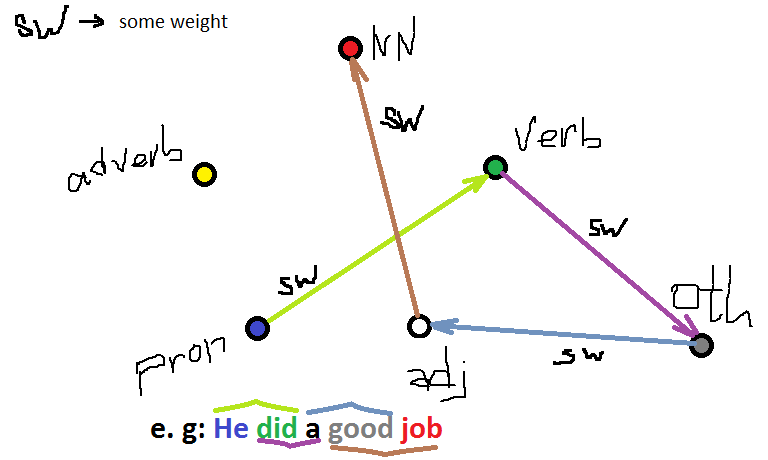

We just count $\sum_{w=1}^{l}sw_i$, Where $ l $ is length of ecxerpt, $sw$ is a single value, not multiplied.
So next step is counting $sw$ as a frequency of the same two-pos sequences 

In [ ]:
tagdict = nltk.data.load('help/tagsets/upenn_tagset.pickle')
possible_tags = sorted([i for i in tagdict.keys() if i.isupper()])

In [ ]:
def tagtag(text):
    
    text = text.lower()
    pattern = r'[a-z]+-[a-z]+|[a-z]+'
    words = re.findall(pattern, text)
    tagged_words = pos_tag(words)
    tags = list(map(lambda x: x[1], tagged_words))
    return tags

In [ ]:
tag2tag = {}
for i in range(sorted_tn.shape[0]):
    tag_list = tagtag(sorted_tn.excerpt[i])
    for j in range(len(tag_list) - 1):
        dbletag = tag_list[j] + tag_list[j + 1]
        if dbletag in tag2tag.keys():
            tag2tag[dbletag] += 1
        else:
            tag2tag[dbletag] = 1

In [ ]:
wsum = sum(tag2tag.values())
for i in tag2tag:
    tag2tag[i] /= wsum

In [ ]:
new_tag2tag = {k: v for k, v in sorted(tag2tag.items(), key=lambda x: x[1], reverse=True)}

In [ ]:
leng = sorted_tn.shape[0]
def tag_to_tag(text):
    
    number = 0
    text = text.lower()
    pattern = r'[a-z]+-[a-z]+|[a-z]+'
    words = re.findall(pattern, text)
    tagged_words = pos_tag(words)
    tags = list(map(lambda x: x[1], tagged_words))
    for j in range(len(tags) - 1):
        dbletag = tags[j] + tags[j + 1]
        number += new_tag2tag[dbletag]
    
    return number

In [ ]:
sorted_tn['to_tag'] = sorted_tn.excerpt.apply(tag_to_tag)
tt['to_tag'] = tt.excerpt.apply(tag_to_tag)

In [ ]:
sns.jointplot(sorted_tn.target, sorted_tn.to_tag)

In [ ]:
sorted_tn

In [ ]:
cols_to_drop = ['id', 'url_legal', 'license', 'excerpt']
tn_excerpts = sorted_tn.excerpt
tt_excerpts = tt.excerpt

In [ ]:
sorted_tn = sorted_tn.drop(cols_to_drop, axis=1)
tt = tt.drop(cols_to_drop, axis=1)

In [ ]:
# if interesting, wait few minutes
# sns.pairplot(sorted_tn[sorted_tn.columns])

In [ ]:
# we have some useless features, at least one of them shown by this example
sns.pairplot(sorted_tn[['nof_sentences', 'avg_len_sentence', 'text_length']])
# later we'll use lasso to know all useless feats

In [ ]:
show_diffs(sorted_tn, features)

In [ ]:
# for now, let's take a look at correlation ratio 
sns.heatmap(sorted_tn[features[2:13]].corr(), annot=True)

Now we're looking a few things 

In [ ]:
sns.heatmap(sorted_tn[features[:13] + ['to_tag']].corr(), annot=True)

In [ ]:
tt_features = []
for j in features:
    if j not in ['standard_error', 'target']:
        tt_features.append(j)

In [ ]:
# just interesting :)
show_diffs(tt, tt_features)

# Summary
Now, I'm going to use lasso to get sparse feature vector. Also I want to implement useful features (I'll get by Lasso) into PyTorch transformer with RobertaTokenizer are both at once. But I don't know how to do it :( It, might, something like a training new model with a pretrained one. If U know, please provide me with link, or your work after the competition ends. Need help :)
If interesting, please upvote and sorry again for my eng... 